In [60]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib notebook

In [61]:
#read data, and generate basic info
unclean = pd.read_csv('../../UM.csv').copy()
print(unclean.head())
print(unclean.shape)
print(unclean.info())

   Number          Primary UMSCUMCC  Age_at_dx     Sex Durationofsymptoms  \
0   13544  First incidence     UMMC         39  female                  1   
1   13001  First incidence     SDMC         33  female                  8   
2   10450  First incidence     UMMC         60  female                0.5   
3   28149  First incidence     UMMC         66  female                  1   
4   26091  First incidence     UMMC         49  female                NaN   

  Marital_status  Age_at_first_child_birth          Meno_stat famhist  \
0        married                      26.0                NaN      no   
1        married                      32.0       Premenopause      no   
2    not married                       NaN  Natural menopause      no   
3        married                      27.0  Natural menopause      no   
4            NaN                       NaN       Premenopause      no   

               ...               Chemotherapy                  Regime  \
0              ...       

In [62]:
#Primary
recode1 = {'First incidence': 1, 'Previous breast cancer': 2}
unclean['Primary'] = unclean['Primary'].map(recode1).astype('category')


In [63]:
#2 - UMSCUMCC 
recode2 = {'UMMC': 1, 'SDMC': 2, 'UMSC':3}
unclean['UMSCUMCC'] = unclean['UMSCUMCC'].map(recode2).astype('category')

In [64]:
#3 - Age_at_dx
unclean['Age_at_dx'] = pd.to_numeric(unclean['Age_at_dx'],errors='coerce')

In [65]:
#4 - Sex 
recode4 = {'female': 1, 'male': 2}
unclean['Sex'] = unclean['Sex'].map(recode4).astype('category')

In [66]:
#5 not doing duration as it is far too messy! (see clean_old and models_old for info on this)

In [67]:
#6 - Marital_status 
recode6 = {'married': 1, 'not married': 0}
unclean['Marital_status'] = unclean['Marital_status'].map(recode6).astype('category')

In [68]:
#7 Age at first child is weird, the data goes to 99...this is immpossible

In [69]:
#8 #8 - Meno_stat 
recode8 = {'Premenopause': 1, 'Natural menopause': 2, 'Surgical menopause': 3}
unclean['Meno_stat'] = unclean['Meno_stat'].map(recode8).astype('category')

In [70]:
#9 - famhist (739 blank)
recode9 = {'no': 0, 'yes': 1}
unclean['famhist'] = unclean['famhist'].map(recode9).astype('category')

In [71]:
#10 - Nationality
recode10 = {'Malaysian': 1, 'Others': 2}
unclean['Nationality'] = unclean['Nationality'].map(recode10).astype('category')

In [72]:
#11 - Race
recode11 = {'Malay': 1, 'Chinese': 2, 'India': 3, 'Others': 4}
unclean['Race'] = unclean['Race'].map(recode11).astype('category')

In [73]:
#12 - diagnosis
recode12 = {'excision': 1, 'FNAC': 2, 'imaging only': 3, 'trucut': 4, 'other': 5}
unclean['diagnosis'] = unclean['diagnosis'].map(recode12).astype('category')

In [74]:
#13 - Classification 
recode13 = {'In situ': 1, 'Invasive': 2}
unclean['Classification'] = unclean['Classification'].map(recode13).astype('category')

In [75]:
#14 - Laterality 
recode14 = {'Bilateral': 1, 'Left': 2, 'Right': 3, 'Unilateral side unknown': 4}
unclean['Laterality'] = unclean['Laterality'].map(recode14).astype('category')

In [76]:
#15 - AJCC6complete 
unclean['AJCC6complete'] = unclean['AJCC6complete'].astype('category')

In [77]:
#16 - STAGEAJCC6 
recode16 = {'Stage 0': 0, 'Stage 1': 1, 'Stage 2': 2, 'Stage 3': 3, 'Stage 4': 4}
unclean['STAGEAJCC6'] = unclean['STAGEAJCC6'].map(recode16).astype('category')

In [78]:
#17 - Differentiation 
recode17 = {'poor differentiation': 1, 'Moderate differentiation': 2, 'Good differentiation': 3}
unclean['Differentiation'] = unclean['Differentiation'].map(recode17).astype('category')

In [79]:
#18 - Tumor_size 
unclean['Tumor_size'] = pd.to_numeric(unclean['Tumor_size'],errors='coerce')

In [80]:
#19 - ER_status
recode19 = {'Positive': 1, 'Negative': 2}

unclean['ER_status'].replace('unknown',np.NaN)
unclean['ER_status'] = unclean['ER_status'].map(recode19).astype('category')

In [81]:
#20 - PR_status 
recode20 = {'Positive': 1, 'Negative': 2}

unclean['PR_status'].replace('unknown',np.NaN)
unclean['PR_status'] = unclean['PR_status'].map(recode20).astype('category')

In [82]:
#21 - CERB2_status (1549 blanks)
recode21 = {'Positive': 1,'Negative': 2, 'Equivocal': 3}
unclean['CERB2_status'] = unclean['CERB2_status'].map(recode21).astype('category')

In [83]:
#22 - Pri_Rx 
recode22 = {'Surgery': 1, 'Chemotherapy': 2,'Hormone therapy': 3, 'Others': 4, 'None': 5}
unclean['Pri_Rx'] = unclean['Pri_Rx'].map(recode22).astype('category')

In [84]:
#23 - Surgery (36 blanks)
recode23 = { 'No surgery': 0, 'surgery done': 1, 'Defaulted': 2}
unclean['Surgery'] = unclean['Surgery'].map(recode23).astype('category')

In [85]:
#24 - Surgery_type (98 blanks)
recode24 = {'Mastectomy': 1, 'Breast conserving surgery': 2, 'No surgery': 3}
unclean['Surgery_type'] = unclean['Surgery_type'].map(recode24).astype('category')

In [86]:
#25 - Axill_dissect (676 blanks)
recode25 = {'Yes': 1, 'None': 2, 'SLNB': 3, 'SLNB TO AC': 4}
unclean['Axill_dissect'] = unclean['Axill_dissect'].map(recode25).astype('category')

In [87]:
#26 date_surg - not needed

In [88]:
#27 - Radiotherapy (1122 blanks)
recode26 = {'No radiotherapy': 0, 'Radiotherapy': 1}
unclean['Radiotherapy'] = unclean['Radiotherapy'].map(recode26).astype('category')

In [89]:
#28 - Chemotherapy (640 blanks)
recode27 = {'No chemotherapy': 0, 'Chemotherapy': 1}
unclean['Chemotherapy'] = unclean['Chemotherapy'].map(recode27).astype('category')

In [90]:
#29 the rest of the data (aside fron Event) have too many blanks and/or are uneeded

In [91]:
#30 - Event
recode36 = {'Dead': 0, 'Alive': 1, 'Repeat pt - contralateral BC': 3, 'Repeat pt - abscond and return': 4, 'Seen in SJMCand UMMC' : 5}
unclean['Event'] = unclean['Event'].map(recode36).astype('category')

In [92]:
#check all is categorical and named correctly:
def print_all_values(df):
    for column in df.columns:
        print("--------------------- %s ---------------------" % column)
        print(df[column].value_counts())

print_all_values(clean)


--------------------- Primary ---------------------
1    2988
2       6
Name: Primary, dtype: int64
--------------------- UMSCUMCC ---------------------
1    1524
2     742
3     728
Name: UMSCUMCC, dtype: int64
--------------------- Age_at_dx ---------------------
48    109
45    109
44    107
50    105
46    104
56    102
53     99
54     97
47     95
52     94
49     93
51     91
43     91
55     86
57     82
58     79
60     77
59     77
63     75
42     74
62     67
41     65
61     62
66     62
40     61
64     56
65     53
67     52
69     50
39     48
     ... 
33     23
73     22
36     22
32     22
74     21
34     20
76     19
75     19
30     16
31     15
77     15
78     12
79     11
80      9
81      9
29      8
82      8
28      8
83      6
27      5
85      5
86      4
24      4
25      3
23      2
87      2
84      1
88      1
26      1
89      1
Name: Age_at_dx, Length: 67, dtype: int64
--------------------- Sex ---------------------
1    2993
2       1
Name: Sex, dty

<IPython.core.display.Javascript object>


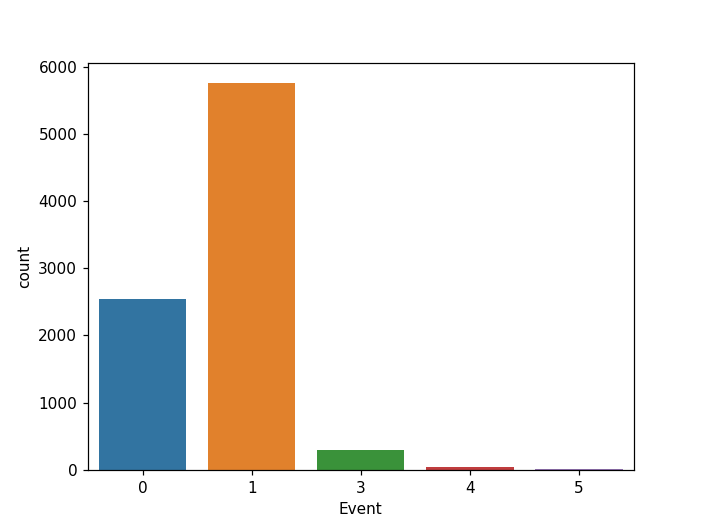

Text(0.5,0,'Event')

In [93]:
sns.countplot(x='Event', data=unclean)
plt.xlabel('Event')

## Get rid of all other events but dead or alive
We will also drop all na values

In [94]:
clean = unclean[['Primary','UMSCUMCC','Age_at_dx','Sex','Marital_status','Meno_stat','famhist',
                 'Nationality','Race','diagnosis','Classification','Laterality','STAGEAJCC6',
                 'Differentiation','ER_status','PR_status','CERB2_status','Pri_Rx','Surgery_type',
                 'Axill_dissect','Radiotherapy','Chemotherapy','Event']].dropna()
clean = clean[(clean['Event']==0) | (clean['Event']==1)]
clean.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2994 entries, 1 to 8590
Data columns (total 23 columns):
Primary            2994 non-null category
UMSCUMCC           2994 non-null category
Age_at_dx          2994 non-null int64
Sex                2994 non-null category
Marital_status     2994 non-null category
Meno_stat          2994 non-null category
famhist            2994 non-null category
Nationality        2994 non-null category
Race               2994 non-null category
diagnosis          2994 non-null category
Classification     2994 non-null category
Laterality         2994 non-null category
STAGEAJCC6         2994 non-null category
Differentiation    2994 non-null category
ER_status          2994 non-null category
PR_status          2994 non-null category
CERB2_status       2994 non-null category
Pri_Rx             2994 non-null category
Surgery_type       2994 non-null category
Axill_dissect      2994 non-null category
Radiotherapy       2994 non-null category
Chemotherapy  

In [95]:
#write newly cleaned data to file
final = clean.copy()
final.to_csv('../../clean_cancer_data.csv', sep='\t',encoding='utf-8')
print(final.shape)

(2994, 23)
